## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
benchmark = False
#binary_dirs = 'binaries_model1_tfrecordz/'
#binary_dirs = 'binaries_model2_tfrecordz/'
#binary_dirs = 'binaries_model3_tfrecordz/'
#binary_dirs = 'binaries_model4_tfrecordz/'
#binary_dirs = 'binaries_model5_tfrecordz/'
#binary_dirs = 'binaries_model6_tfrecordz/'
#binary_dirs = 'binaries_model7_tfrecordz/'
#binary_dirs = 'binaries_model8_tfrecordz/'
#binary_dirs = 'binaries_model9_tfrecordz/'
#binary_dirs = 'binaries_model10_tfrecordz/'
#binary_dirs = 'binaries_model11_tfrecordz/'
#binary_dirs = 'binaries_model12_tfrecordz/' # winner winner, chicken dinner
#binary_dirs = 'binaries_model13_tfrecordz/'
#binary_dirs = 'binaries_model14_tfrecordz/'
#binary_dirs = 'binaries_model15_tfrecordz/'
ioustar = [0.9] # fig, caption
# use CV or no?
use_cv = True # only applies to saving of .dat files
save_no_post_proc = False # also save w/o post processing
fig_save_dir = None


# plot post-processing steps?
plot_post_proc = False


# # for final-final test -- ours on our data (1st table)
# binary_dirs = 'binaries_model12_finaltest/'# for final test set
# ioustar = [0.1,0.6,0.8] # fig, caption
# use_cv = True # only applies to saving of .dat files
# save_no_post_proc = False # also save w/o post processing

# for final-final test, 2nd table -- ours on our data (2nd table)
binary_dirs = 'binaries_model12_finaltest/'# for final test set
ioustar = [0.9] # fig, caption
use_cv = False # only applies to saving of .dat files
save_no_post_proc = True # also save w/o post processing
fig_save_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/figures/'


# # # How well does our model do on non-commericial PubLayNet pages?
# binary_dirs = 'binaries_model12_tfrecordz_pmcnoncom/'
# # # for benchmarks,ioustar defaults to 0.6 or 0.9
# benchmark = True
# ioubench = 0.9
# save_no_post_proc = False # also save w/o post processing
# use_cv = False


# # # How well does our model do on scanbank pages?
# binary_dirs = 'binaries_model12_scanbank/'
# # # for benchmarks,ioustar defaults to 0.6 or 0.9
# benchmark = True
# ioubench = 0.9
# use_cv = False
# save_no_post_proc = False # also save w/o post processing


seed = 5 # set seed for CV -- good if you wanna compare things


# do we want to store any diagnostic plots (this will slow things down)
store_diagnostics = False # set to False or None if you don't want to

In [2]:
use_valid = False # should always be false, just take out

# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
#any extra tag to anything
adder_dats = ''
# which iou's to save?
#ioustar = [0.9,0.95] # fig, caption
#ioustar = [0.1,0.6,0.9] # fig, caption
scorestar = 0.1

if benchmark: ioustar = [ioubench]

adder = ''
#adder = 'colorbar'
#adder = 'truebox'

if use_valid: adder = '_valid'

How do we want to quantify how well we are doing?

In [3]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
#####if not use_cv: n_folds_cv = 1
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [4]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe, calc_AP
from general_utils import create_destroy_dirs

In [5]:
diagnostics_dir = config.tmp_storage_dir
if store_diagnostics is None: store_diagnostics = config.store_diagnostics
    
if store_diagnostics:
    for d in ['FN/','FP/','TP/']:
        create_destroy_dirs(diagnostics_dir+d)

In [6]:
# # debugging
# import metric_utils
# reload(metric_utils)
# from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [7]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += adder
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)

In [8]:
len(imgs_name)

830

In [9]:
config.metric_results_dir

'/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'

Final box analytics:

In [10]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)

In [11]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [12]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/var/folders/t7/bwcvd_4177q4872gxghn7p9r0000gq/T/ipykernel_32764/2364860595.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(ps, labels=LABELS)


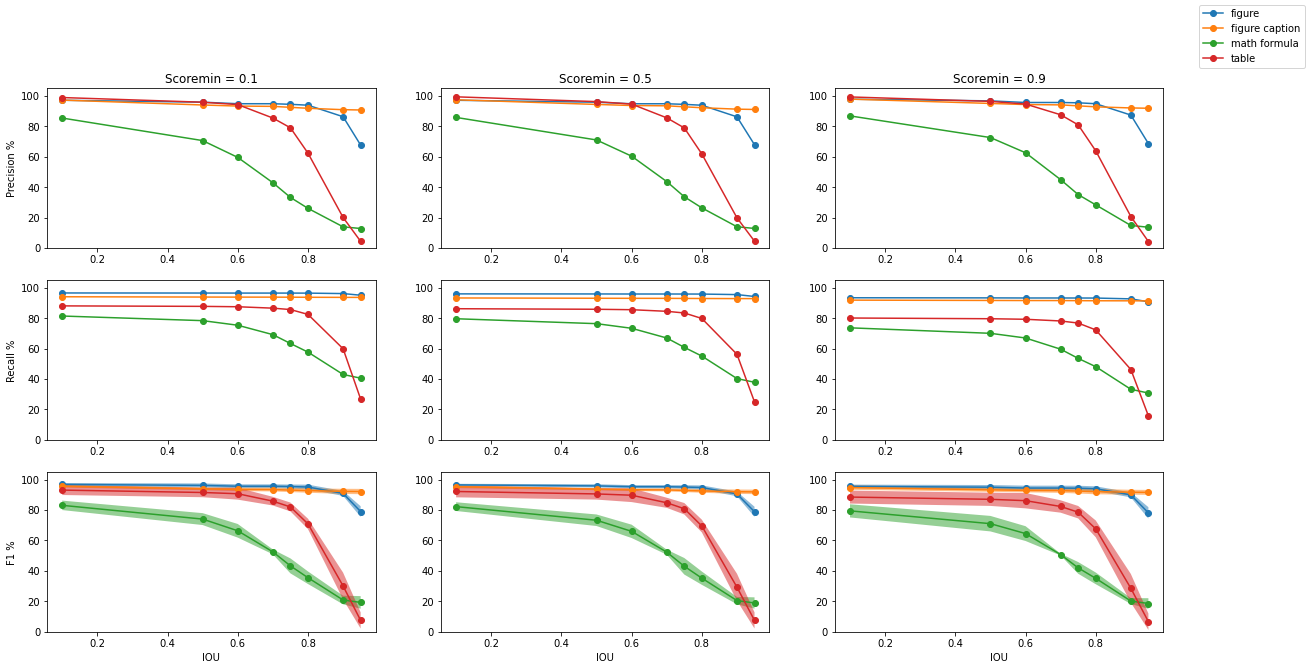

In [13]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [14]:
scoremin = 0.1

Also calculate mAP/AP using the COCO ranges:

In [15]:
aps = calc_AP(truebox3,boxes_sq5,labels_sq5, scores_sq5,LABELS, 
            scoreMin = [scoremin])

In [16]:
for il,l in enumerate(LABELS):
    print(l, 'AP = ', round(aps[il]*100,2))

figure AP =  91.51
figure caption AP =  87.91
math formula AP =  44.02
table AP =  72.23


What IOU cut-offs for each label? for reference:

In [17]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [18]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.6] # fig, fig+caption, math formula, table

In [19]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [20]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [21]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.6            
# of objs       490             487             318             218            
--------------------------------------------------------------------------------------------
TP              85.7%           86.4%           22.6%           83.5%          
FP              13.7%           8.8%            64.5%           5.0%           
FN              3.5%            6.0%            17.0%           12.4%          
--------------------------------------------------------------------------------------------
Precision       86.3+/-3.2%     90.7+/-2.4%     26.1+/-4.1%     94.2+/-2.0%    
Recall          96.1+/-1.0%     93.6+/-1.5%     57.7+/-8.6%     87.5+/-5.7%    
F1              90.9+/-1.6%     92.1+/-1.7%     35.5+/-4.1%     90.7+/-3.9%    


In [59]:
#len(imgs_name)
#len(truebox3)

In [23]:
#Shape is: (# labels, #scores, #ious, #CV folds)
iousStandard = [0.8,0.8,0.8,0.8]
iousStandard = [0.6,0.6,0.6,0.6]
iousStandard = [0.9,0.9,0.9,0.9]

# TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iousStandard,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               iousStandard)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, iousStandard)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       490             487             318             218            
--------------------------------------------------------------------------------------------
TP              85.7%           86.7%           12.3%           17.9%          
FP              13.7%           8.6%            74.8%           70.6%          
FN              3.5%            6.0%            17.0%           12.4%          
--------------------------------------------------------------------------------------------
Precision       86.3+/-3.2%     90.9+/-2.3%     14.0+/-1.6%     20.1+/-5.8%    
Recall          96.1+/-1.0%     93.6+/-1.5%     43.0+/-10.0%    59.9+/-18.1%   
F1              90.9+/-1.6%     92.2+/-1.7%     20.9+/-2.8%     30.1+/-8.8%    


If we want to store diagnostics, loop and calculate TP,FP,FN for all and save as figs.  Note: this will slow things down!

In [24]:
iouDiag = 0.9
uptoInd = 2 # only figs, fig captions
if store_diagnostics:
    for ic,(iname,tb,fb,lb,sb) in enumerate(zip(imgs_name,truebox3,boxes_sq5,labels_sq5,scores_sq5)):
        if ic%50 == 0: print('on', ic, 'of', len(imgs_name))
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[iouDiag],
                                                  [tb],[fb],[lb], [sb],n_folds_cv=1)
        iiname = config.images_jpeg_dir+iname.split('/')[-1].rstrip('.npz')+'.jpeg'
        img = np.array(Image.open(iiname).convert('RGB'))
        xfrac = img.shape[1]/config.IMAGE_W
        yfrac = img.shape[0]/config.IMAGE_H
        for met,metdir in zip([TPs, FPs, FNs],['TP','FP','FN']): # loop over all metrics
            if np.sum(met[:uptoInd].flatten()) > 0: # have at least one hit
                for bb in tb: # draw true
                    if bb[-1] < uptoInd+1: # only for select ones
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (0,0,255), 5)
                for bb,ll in zip(fb,lb): # draw found
                    if ll <uptoInd:
                        xmin=round(bb[0]*xfrac); xmax = round(bb[2]*xfrac)
                        ymin=round(bb[1]*yfrac); ymax=round(bb[3]*yfrac)
                        cv.rectangle(img, (round(xmin), round(ymin)), 
                                     (round(xmax),round(ymax)), (255,0,0), 5)

                # save
                Image.fromarray(img).save(diagnostics_dir+metdir+'/'+ iname.split('/')[-1].rstrip('.npz')+'.jpeg')

In [25]:
#labels_sq5

## Vs. Time
Also, let's plot metrics vs. year.

In [26]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [27]:
np.random.randint(1900,2000,5)

array([1918, 1930, 1996, 1922, 1943])

In [28]:
try:
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)
except:
    print('years are faked...')
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5, 
                            fake_years=True)

In [29]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1852-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1896-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1897-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1898-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1900-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
sampleHist = '10Y' # 5 years

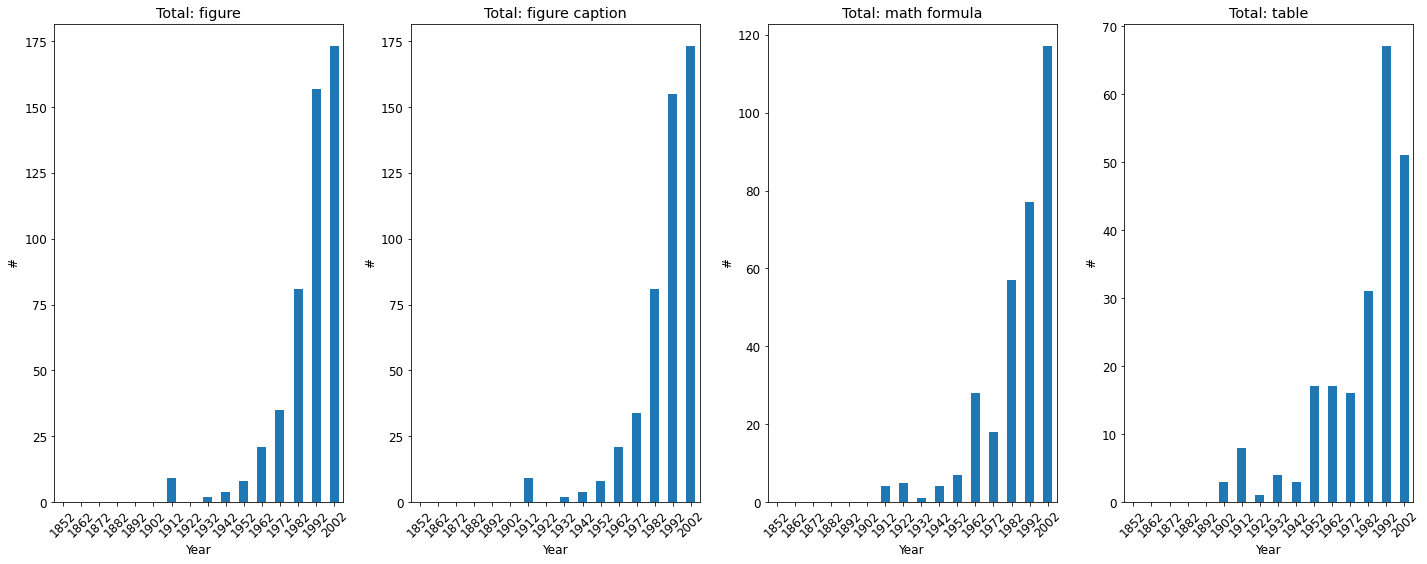

In [31]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

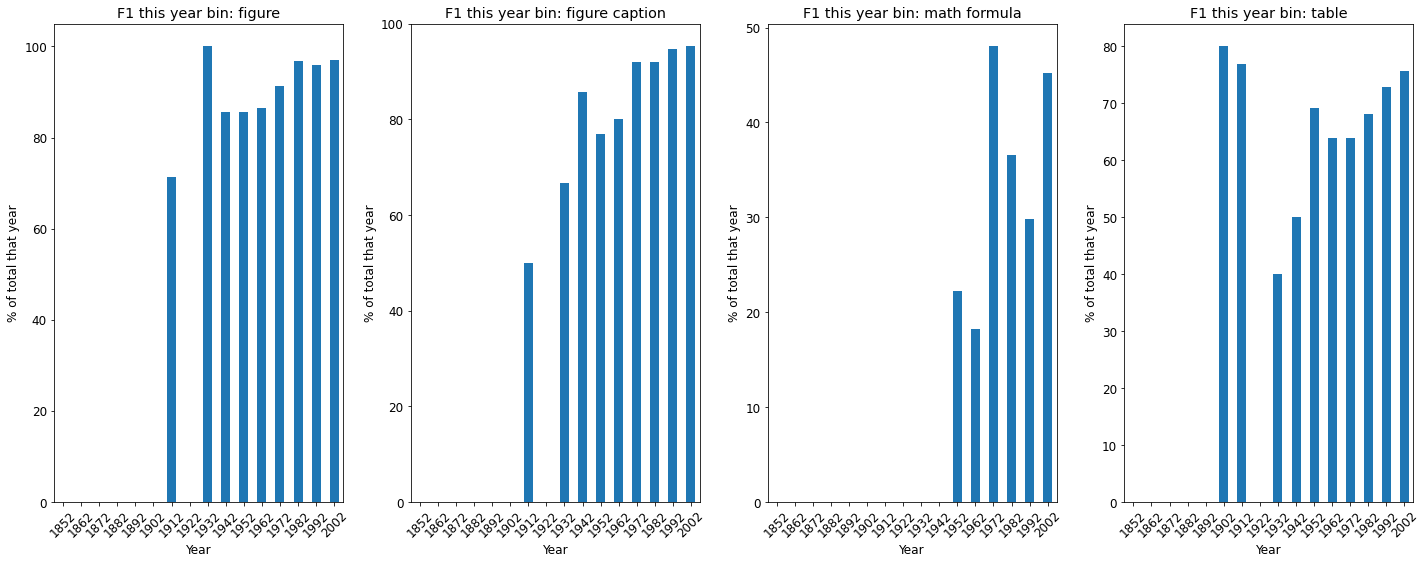

In [32]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

For the paper -- save the f1 and number.

In [33]:
#df['years'].values.astype('str')[:3]
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1852-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1896-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1897-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1898-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1900-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


min year in test dataset= 1903-01-01 00:00:00
IOU threshold for this calculation =  0.8
saved /Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/figures/binaries_model12_finaltestyear_distribution_F1.pdf


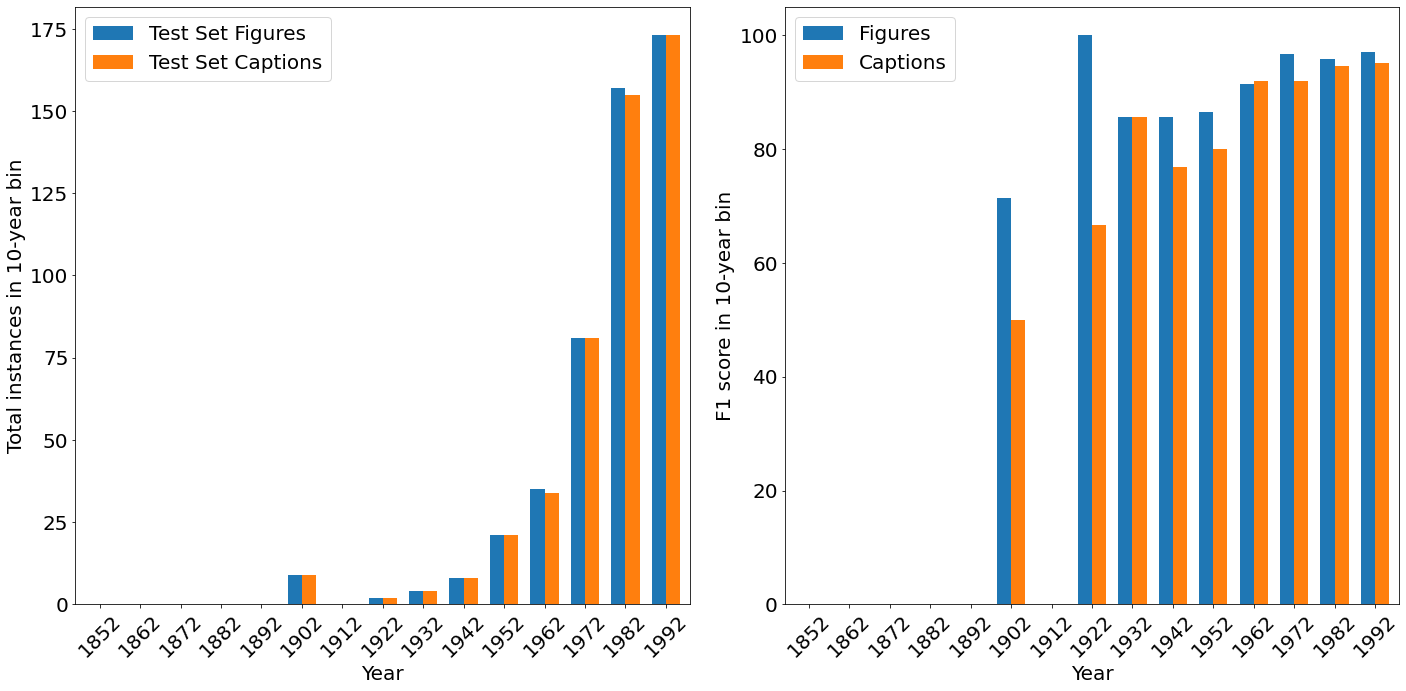

In [34]:
if fig_save_dir is not None:
    year_bins = np.arange(1852, 1992+10+10,10) # match with the pdfmining results
    #print(year_bins)
    tp_fig_bin = np.zeros(len(year_bins)-1)
    fp_fig_bin = tp_fig_bin.copy(); fn_fig_bin = tp_fig_bin.copy()
    tp_cap_bin = tp_fig_bin.copy(); fp_cap_bin = tp_fig_bin.copy()
    fn_cap_bin = tp_fig_bin.copy()
    years_here = []
    tot_fig = np.zeros(len(year_bins)-1); tot_cap = tot_fig.copy()
    yy = df['years'].values.astype('str')
    for i in range(len(df)):
        years_here.append(int(yy[i][:4]))
    for iy,y in enumerate(year_bins[:-1]):
        inds = np.where((years_here<=year_bins[iy+1])&(years_here>year_bins[iy]))[0]
        if len(inds)>0:
            tp_fig_bin[iy] = df['TP:figure'].values[inds].sum()
            fp_fig_bin[iy] = df.iloc[inds]['FP:figure'].sum()
            fn_fig_bin[iy] = df.iloc[inds]['FN:figure'].sum()
            tp_cap_bin[iy] = df.iloc[inds]['TP:figure caption'].sum()
            fp_cap_bin[iy] = df.iloc[inds]['FP:figure caption'].sum()
            fn_cap_bin[iy] = df.iloc[inds]['FN:figure caption'].sum()
            tot_fig[iy] = df.iloc[inds]['total:figure'].sum()
            tot_cap[iy] = df.iloc[inds]['total:figure caption'].sum()
            
    # calc f1
    with np.errstate(invalid='ignore'):
        # figures
        prec_fig = tp_fig_bin/(tp_fig_bin + fp_fig_bin)
        prec_fig[tp_fig_bin + fp_fig_bin == 0] = 0
        rec_fig = tp_fig_bin/(tp_fig_bin + fn_fig_bin)
        rec_fig[tp_fig_bin + fn_fig_bin == 0] = 0
        f1_fig = 2.0 * prec_fig*rec_fig/(prec_fig + rec_fig)
        f1_fig[prec_fig + rec_fig==0] = 0
        # captions
        prec_cap = tp_cap_bin/(tp_cap_bin + fp_cap_bin)
        prec_cap[tp_cap_bin + fp_cap_bin == 0] = 0
        rec_cap = tp_cap_bin/(tp_cap_bin + fn_cap_bin)
        rec_cap[tp_cap_bin + fn_cap_bin == 0] = 0
        f1_cap = 2.0 * prec_cap*rec_cap/(prec_cap + rec_cap)
        f1_cap[prec_cap + rec_cap==0] = 0
    
    dfs = pd.DataFrame({'years':year_bins[:-1],'Test Set Figures':tot_fig, 
                        'Figures':f1_fig*100, 'Test Set Captions':tot_cap, 
                       'Captions': f1_cap*100})
    dfs['years'] = pd.to_datetime(dfs['years'],format="%Y")
    print('min year in test dataset=', df.loc[df['total:figure']>0]['years'].min())
    print('IOU threshold for this calculation = ', ioumin)
    dfs = dfs.set_index('years')
    
    # plot it!
    font = {'weight':'normal','size'   : 20}
    matplotlib.rc('font', **font)
    #fig, ax = plt.subplots(2,1, figsize=(10,20))
    fig, ax = plt.subplots(1,2, figsize=(20,10)) # tpdl
    # tot figs
    dfs.plot(y=['Test Set Figures','Test Set Captions'],kind='bar', 
             ax=ax[0], width=0.7, stacked=False)
    ax[0].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    # # tot captions
    # dfs.plot(y='Test Set Figures',kind='bar', ax=ax[0][0], width=0.7)
    # ax[0][0].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    ax[0].set_ylabel('Total instances in 10-year bin')
    ax[0].set_xlabel('Year')

    dfs.plot(y=['Figures','Captions'],kind='bar', 
             ax=ax[1], width=0.7, stacked=False)
    ax[1].set_xticklabels([x.strftime("%Y") for x in dfs.index], rotation=45)
    ax[1].set_ylabel('F1 score in 10-year bin')
    ax[1].set_xlabel('Year')    

    fig.tight_layout()

    figoutname = fig_save_dir + binary_dirs.replace('/','') + 'year_distribution_F1.pdf'
    print('saved', figoutname)
    fig.savefig(figoutname)
    
    #plt.show()
    matplotlib.style.use('default')

In [35]:
tp_fig_bin

array([  0.,   0.,   0.,   0.,   0.,   5.,   0.,   2.,   3.,   6.,  16.,
        32.,  76., 150., 167.])

In [36]:
journals = ['ApJ', 'AJ', 'ApJS']
mono_figs_j = [mono_figs_apj, mono_figs_aj, mono_figs_apjs]
mono_tabs_j = [mono_tabs_apj, mono_tabs_aj, mono_tabs_apjs]

years = years_save.copy()
mono_figs = np.zeros(len(years)-1); mono_tabs = mono_figs.copy()
totals = mono_figs.copy()
yearsOut = []
for iy,y in enumerate(years[:-1]):
    inds = np.where((dfgrobid['Year'].values<=years[iy+1])&(dfgrobid['Year'].values>years[iy]))[0]
    if len(inds)> 0:
        #totals[iy]=len(inds)
        #mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/totals[iy]*100
        #mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/totals[iy]*100
        mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/len(dfgrobid)*100
        if mono_figs[iy] > 7: import sys; sys.exit()
        mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/len(dfgrobid)*100
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
    for j,mj,tj in zip(journals,mono_figs_j,mono_tabs_j):
        dfpdfh = dfgrobid.loc[dfgrobid['article']==j]
        if len(dfpdfh)>0:
            inds = np.where((dfpdfh['Year'].values<=years[iy+1])&(dfpdfh['Year'].values>years[iy]))[0]
            if len(inds)>0:
                tot = len(inds)
                #tot = len(dfpdfh)
                mj[iy] = np.sum(dfpdfh['mono2_figs'].values[inds])/tot*100
                tj[iy] = np.sum(dfpdfh['mono2_tabs'].values[inds])/tot*100
                
dfgrobid2 = pd.DataFrame({'years':yearsOut,'mono_figs':mono_figs, 'mono_tabs':mono_tabs,
                          'mono_figs_apj':mono_figs_apj, 'mono_figs_aj':mono_figs_aj, 'mono_figs_apjs':mono_figs_apjs,
                        'mono_tabs_apj':mono_tabs_apj, 'mono_tabs_aj':mono_tabs_aj, 'mono_tabs_apjs':mono_tabs_apjs})
dfgrobid2 = dfgrobid2.set_index('years')

dfgrobid['Year'] = pd.to_datetime(dfgrobid['Year'],format="%Y")

NameError: name 'mono_figs_apj' is not defined

Some other metrics:

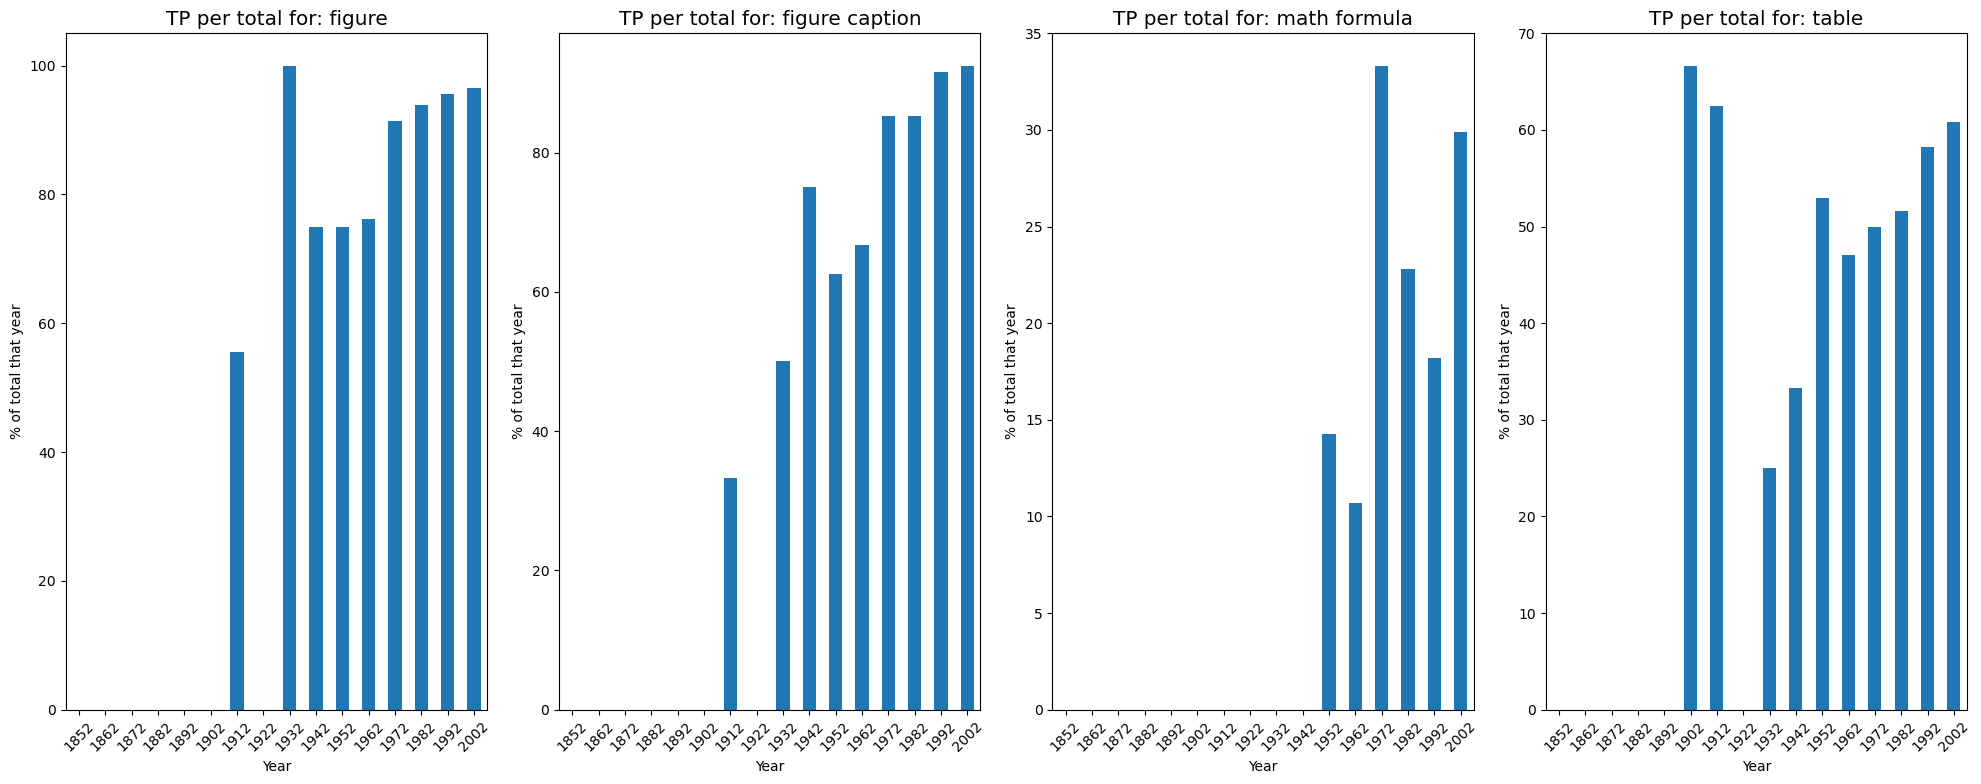

In [37]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

/var/folders/t7/bwcvd_4177q4872gxghn7p9r0000gq/T/ipykernel_32764/1185376556.py:13: RuntimeWarning: divide by zero encountered in true_divide
  quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))


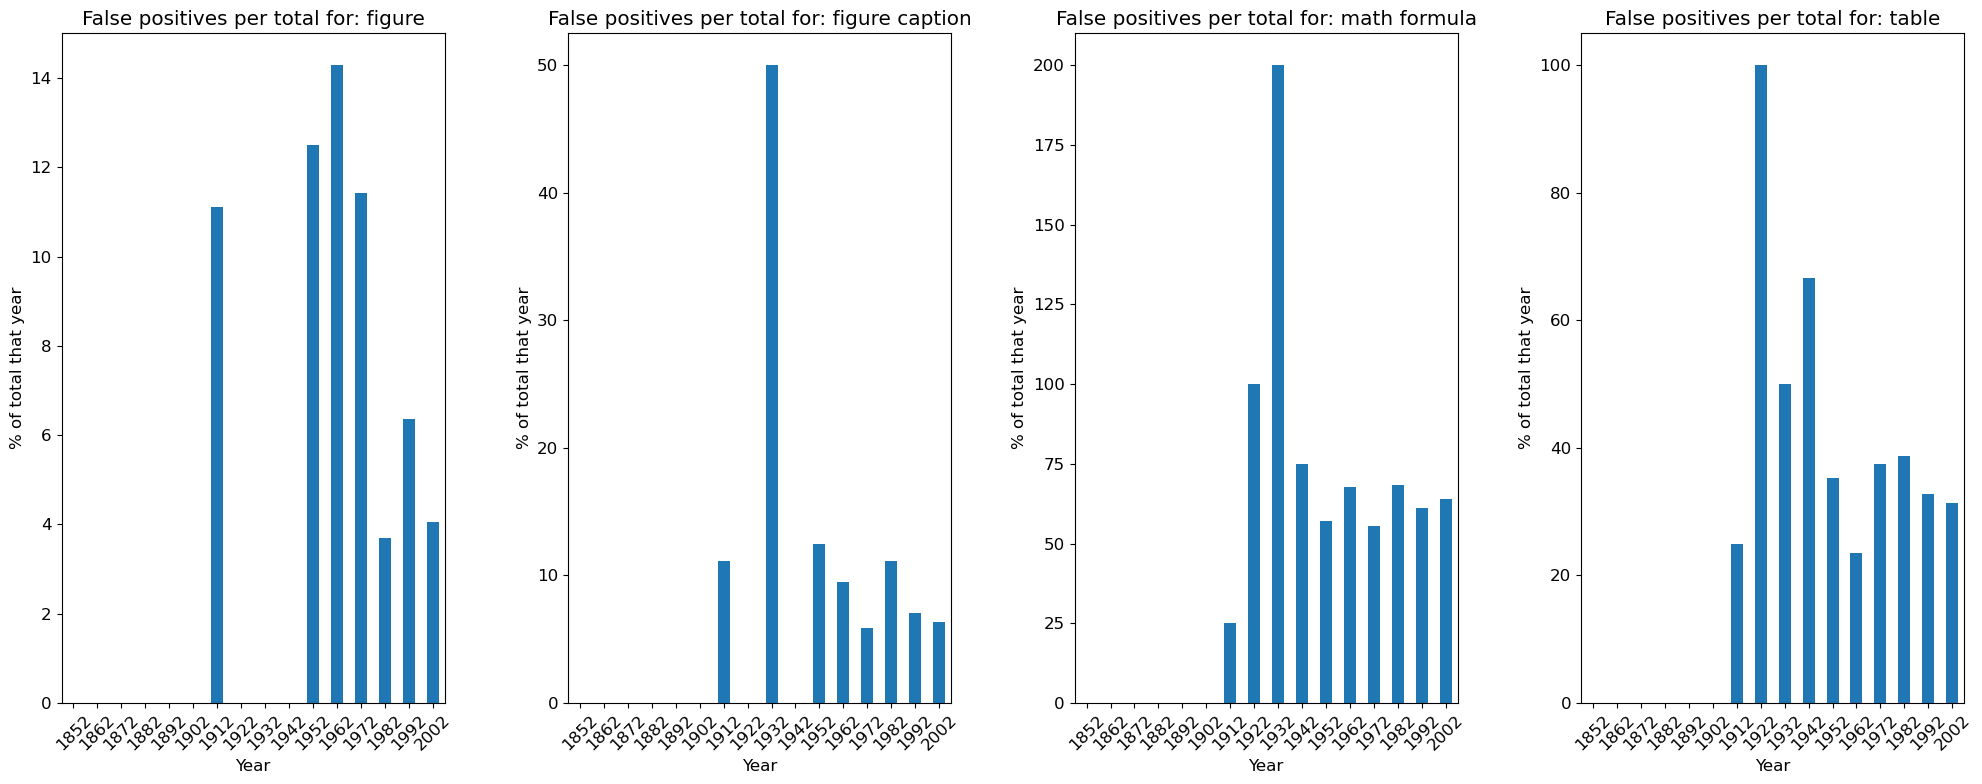

In [38]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

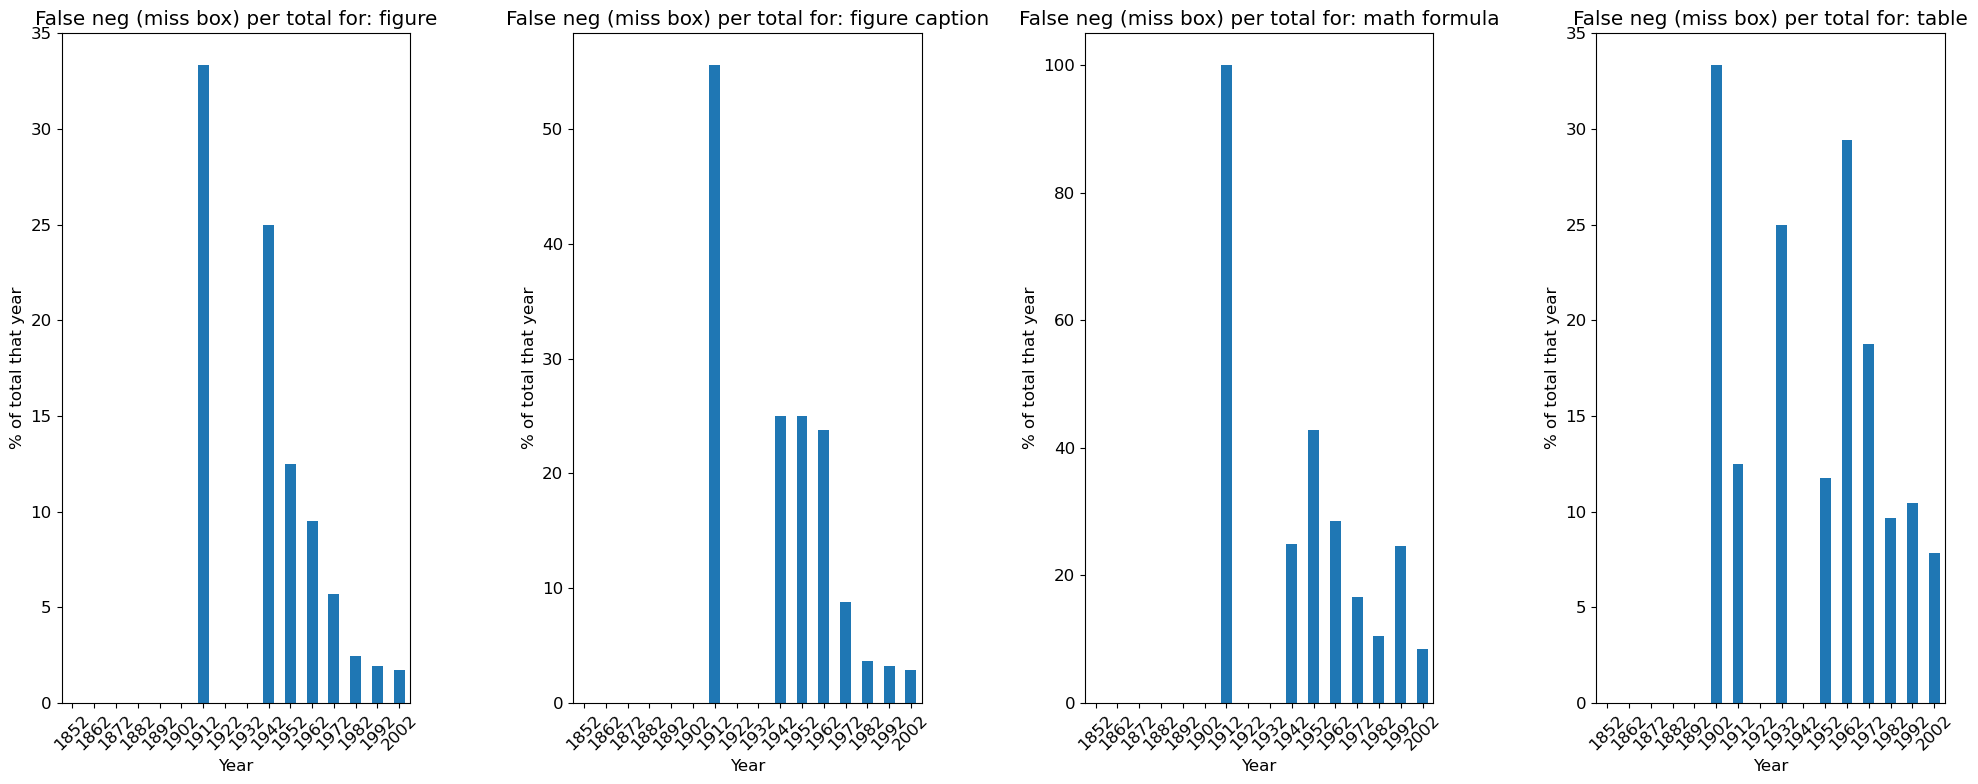

In [39]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

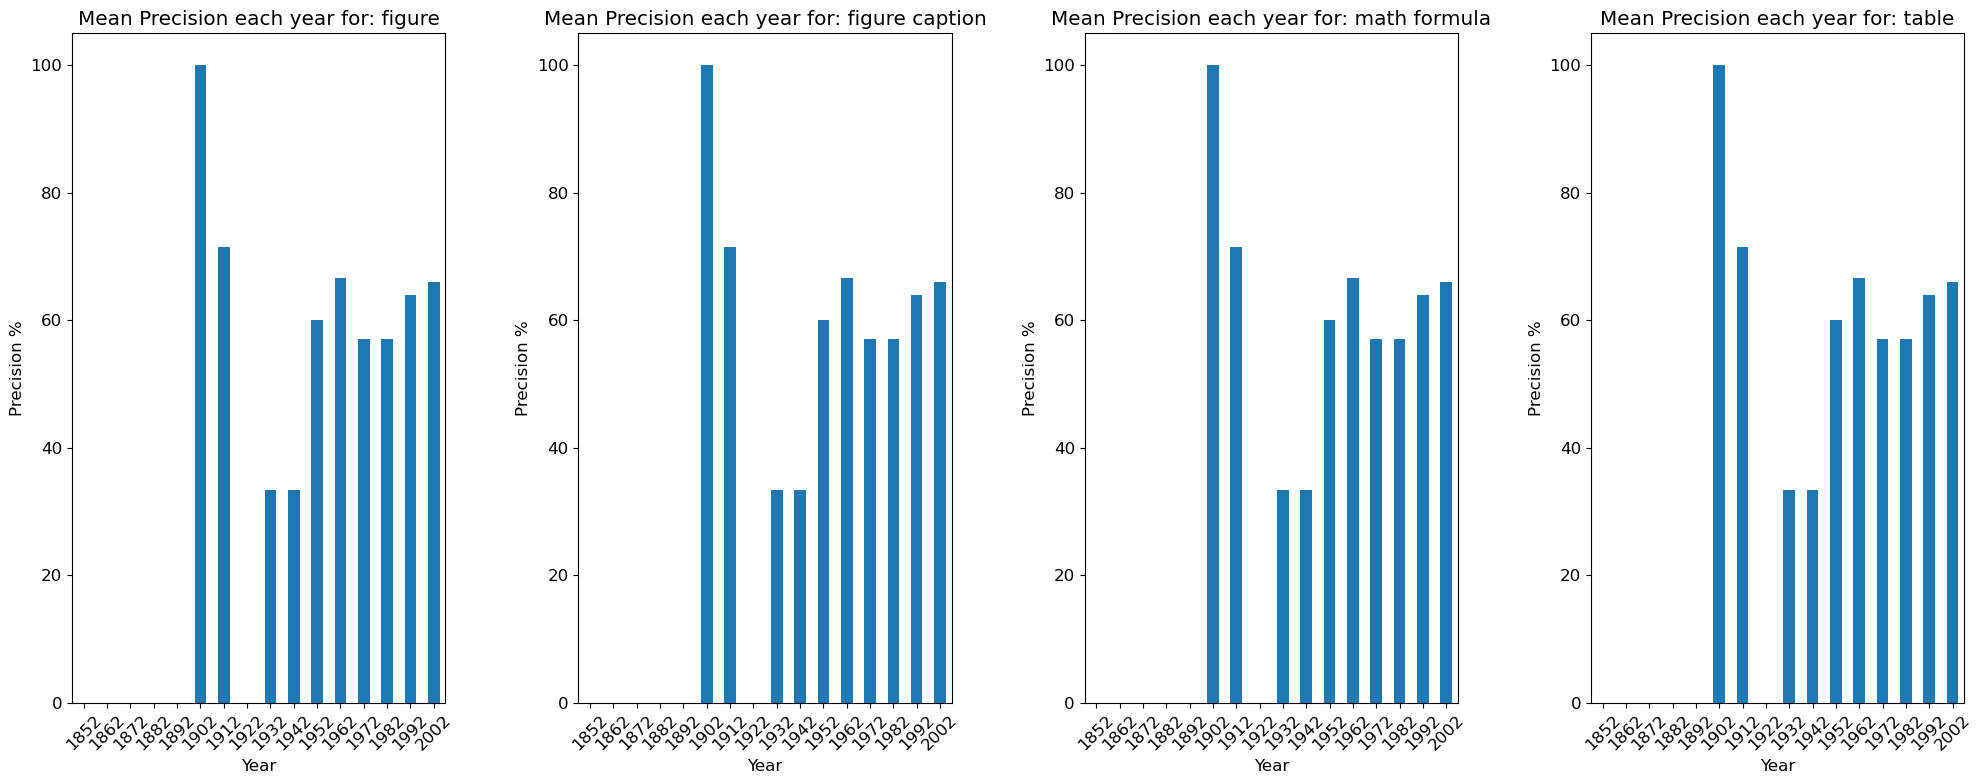

In [40]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

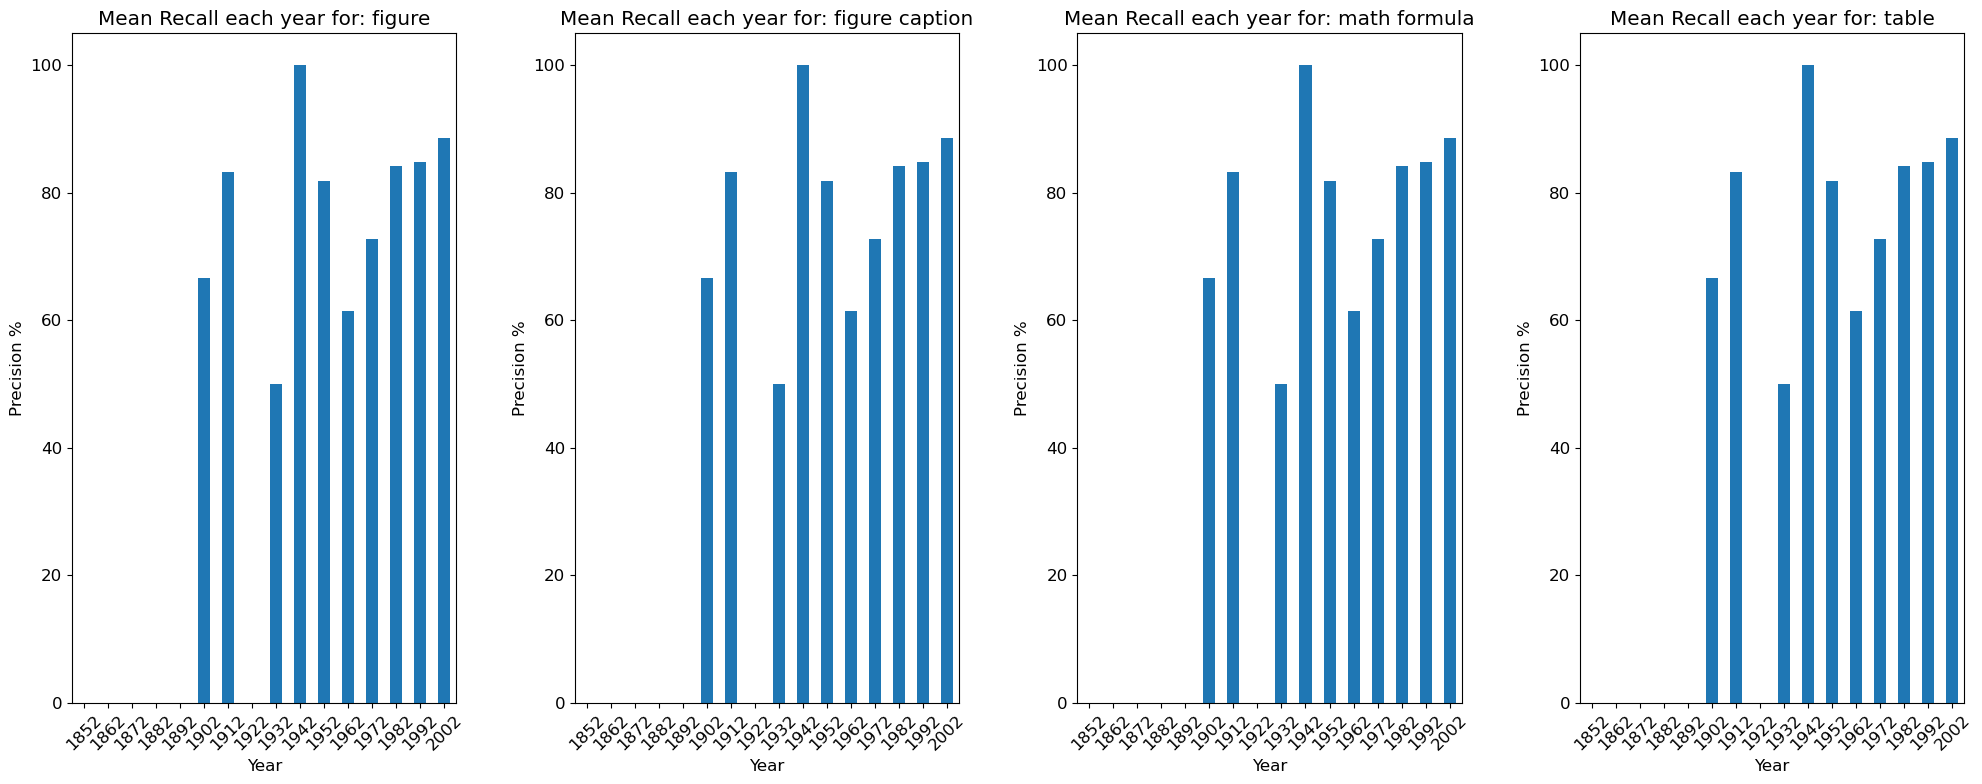

In [41]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

Order of comparisons:

1. Raw true vs raw found (after non-max suppression is applied)
1. If two found boxes overlap with IOU>=0.25, take the one that has the highest score
1. Add in PDF-mining boxes to found boxes.  If caption box overlaps with PDF raw box or a PDF figure caption box, use the PDF-mining box (other things happen with tables that we ignore here).
1. Merge with heuristically-found figure captions.  Take the top of the heuristically-found box and the min/max of the sides and bottom of heuristic box and mega-yolo found box.
1. ~~Add in heuristic-only found captions~~
1. Grow found *and* true figure captions by overlap with OCR-found words and paragraphs.  
   * **does this make wrong trueboxes??**
1. Overlap found figure boxes with image-processing heuristically found boxes -- grow figure boxes by image-processing boxes.
1. Take out super big captions -- captions that are 75% of the area of the page.
1. Match figure captions with figures.  Figures can exist without captions, captions cannot exist without a figure -- if figure caption has no accompanying caption then drop this figure caption. ~~Preference for mega-yolo found captions, if none found, use heuristic-only found captions.~~
1. Expand both true and found figure boxes down to top associated caption boxes (this expands the figure boxes "vertically" down).
1. For both true and found boxes -- if caption box is horizontally larger than the figure box, expand the figure box horizontally to match width of caption box.


## Plot how metrics change with steps

In [42]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [43]:
# order of post-procesings
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             #truebox, #5
             truebox1, #6
             truebox1, #7
             truebox1, #8
             truebox1, #9
             truebox2, #10
             truebox3] #11
foundboxes = [boxes1,#1
              sboxes_cleaned, #2
              boxes_pdf, #3
              boxes_heur,#4
              #boxes_heur2, #5
              boxes_par_found, 
              boxes_sq1, 
              boxes_sq2, #6 --
              boxes_sq3, #6 --
              boxes_sq4, #7
              boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            #labels_heur2,
             labels_par_found,
             labels_sq1,
             labels_sq2,
             labels_sq3,
             labels_sq4,
             labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            #scores_heur2,
             scores_par_found,
             scores_sq1,
             scores_sq2,
             scores_sq3,
             scores_sq4,
             scores_sq5]

In [44]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

(10, 10, 10, 10)

In [49]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []
ttsave = []

plot_post_proc=True
if plot_post_proc:
    for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
        TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                      t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
        # combo metrics
        precisions, precision_stds, recalls, \
          recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                       LABELS,[scoremin],
                                                       iouvec2)

        TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
        ttsave.append(totalTrues[:,:].sum(axis=-1))
        precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
        #import sys; sys.exit()

In [50]:
#labels1
if plot_post_proc:
    np.array(TPsave).shape, TPs.shape, totalTrues.shape

In [51]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

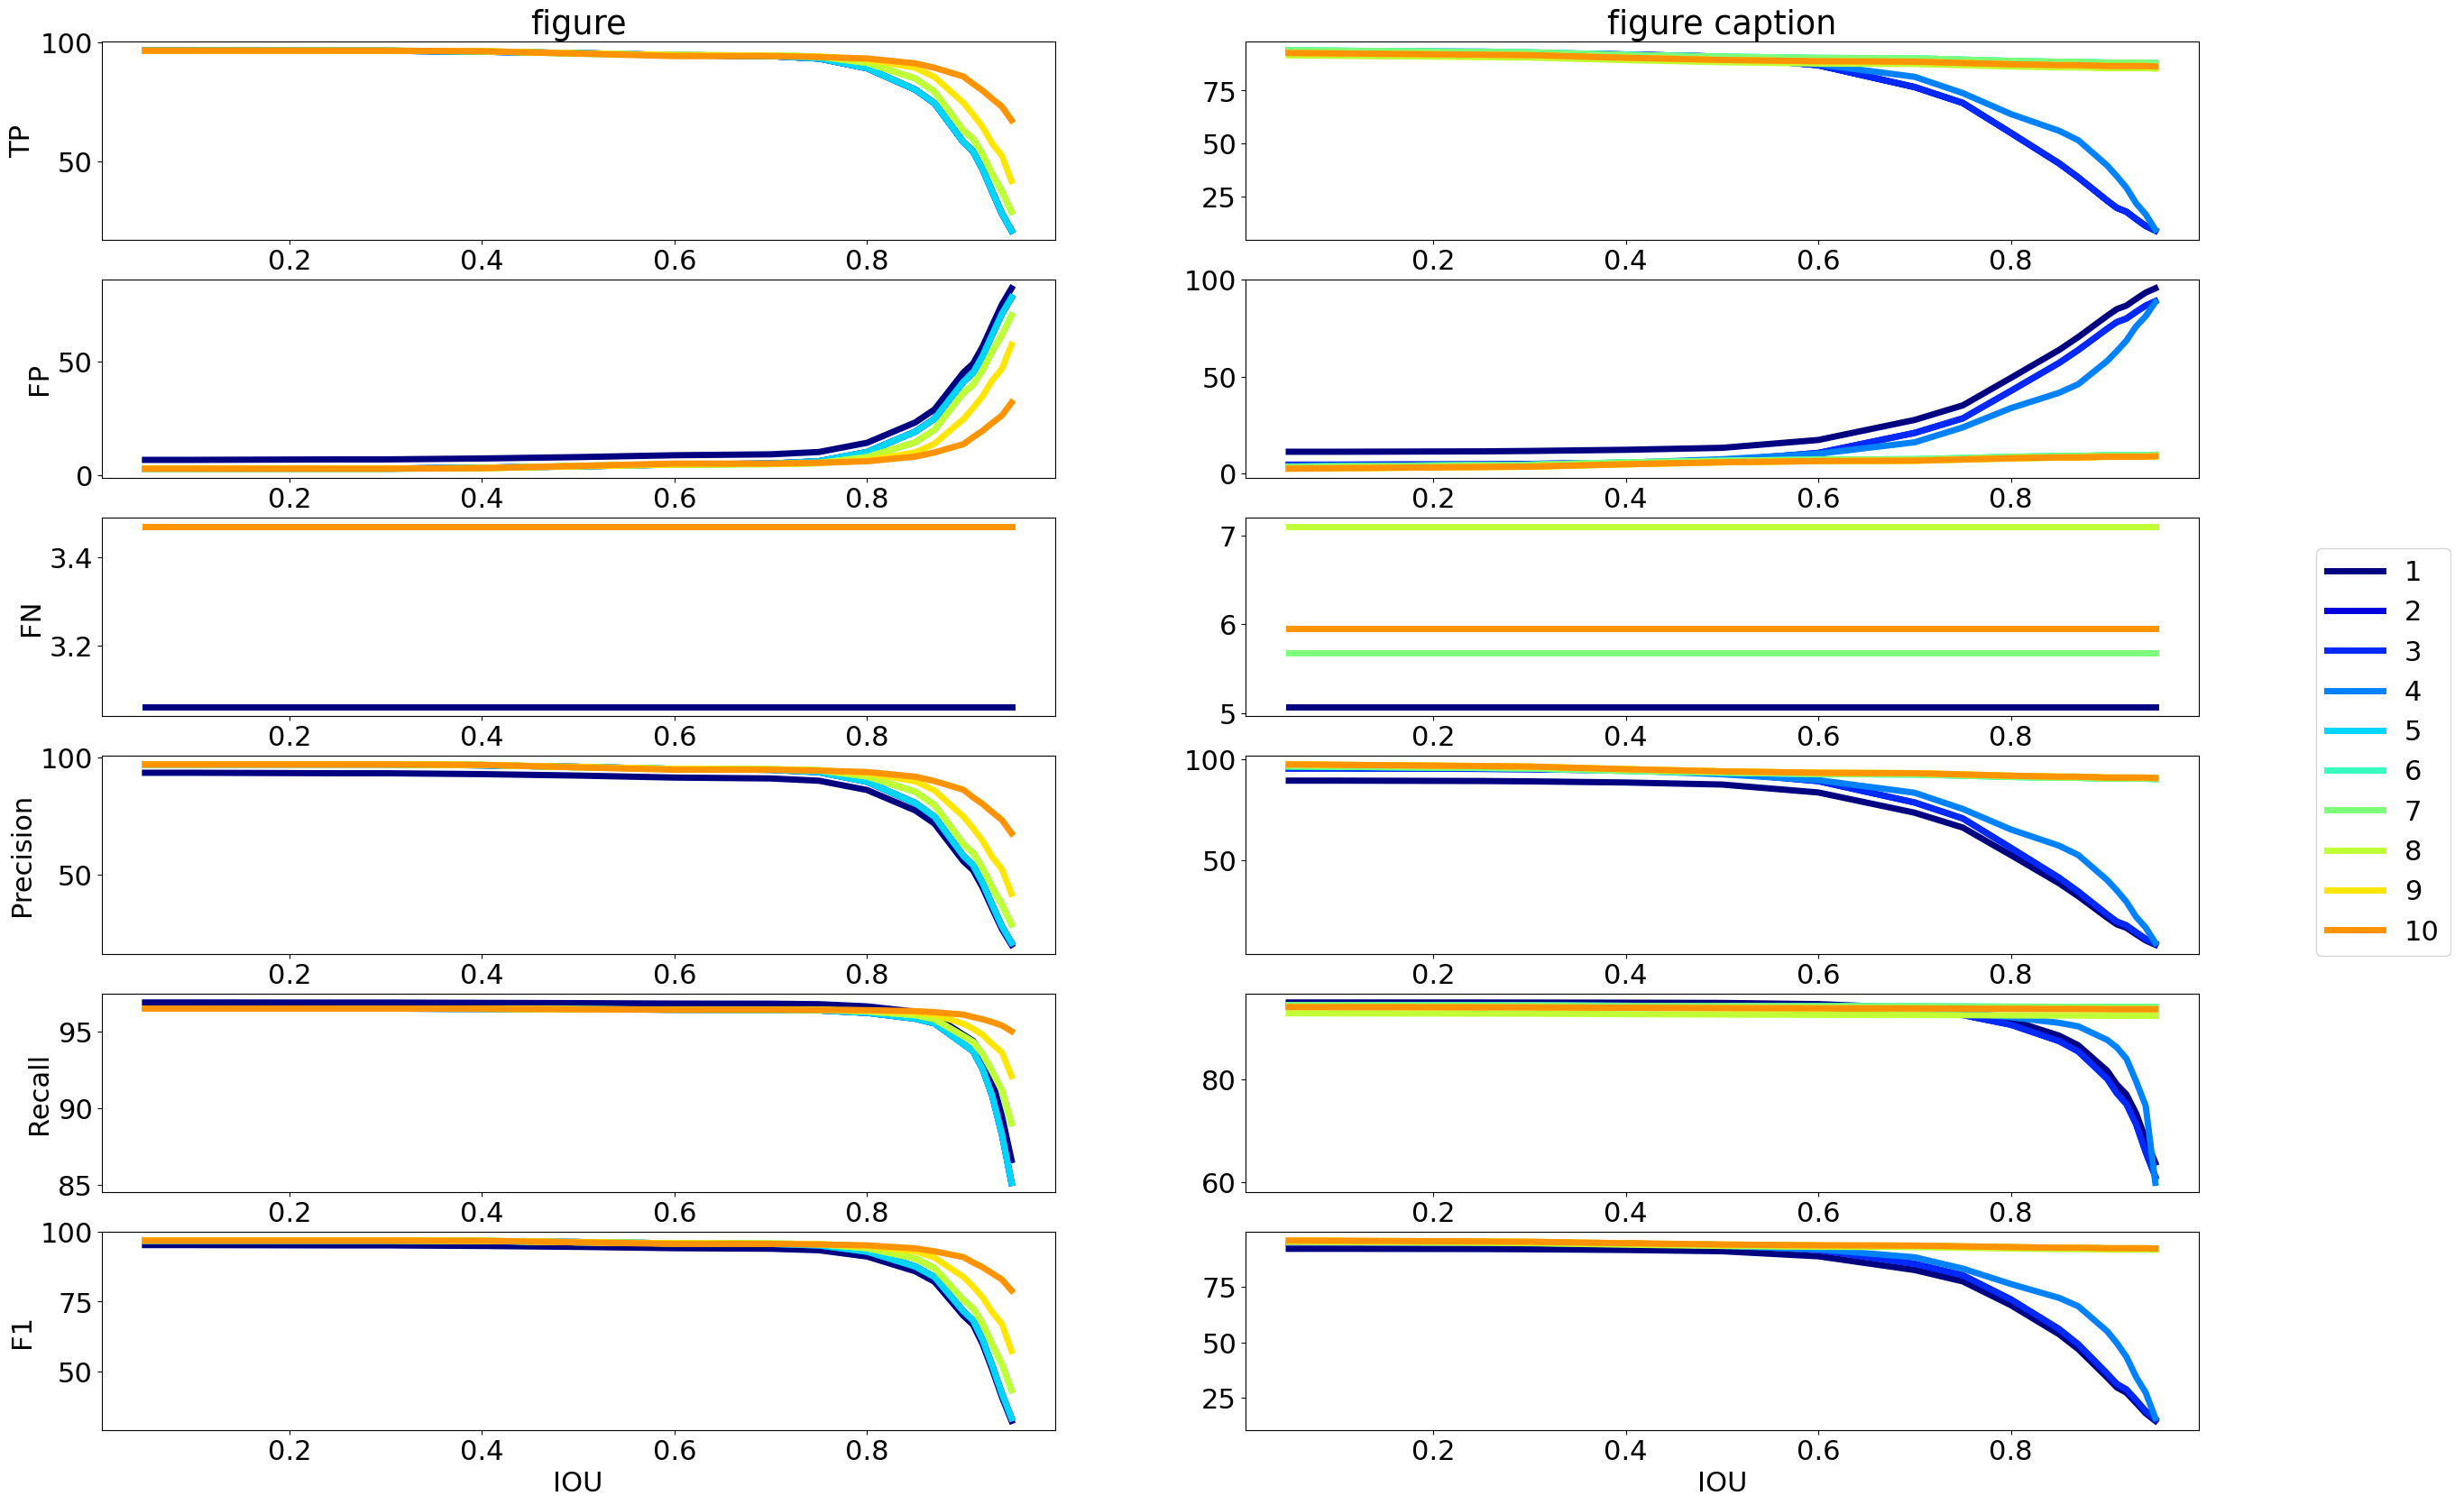

In [52]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 22})

if plot_post_proc:
    fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        #lwh=5
        #if ip==8: lwh=10
        #lwh = 8-ip
        for il in range(len(LABELS[:2])):
            if not divide_tt:
                ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
                if il == 0:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
            else:
                ax[0][il].plot(iouvec2, tp[il]/tt[il]*100,color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, fp[il]/tt[il]*100,color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, fn[il]/tt[il]*100,color=colors[ip],lw=lwh)
                if il == 0:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)

    for k in range(6): 
        ax[k][0].set_ylabel(ylabels[k])
        #for j in range(len(LABELS[:2])):
        #    ax[k][j].set_yscale('log')

    ax[0][0].set_title('figure')
    ax[0][1].set_title('figure caption')
    ax[5][0].set_xlabel('IOU')
    ax[5][1].set_xlabel('IOU')

    fig.legend(loc='center right')
    plt.show()

If you're building up different post-processing steps, check out the ratio of the last two.

Negative = drop, positive = increase

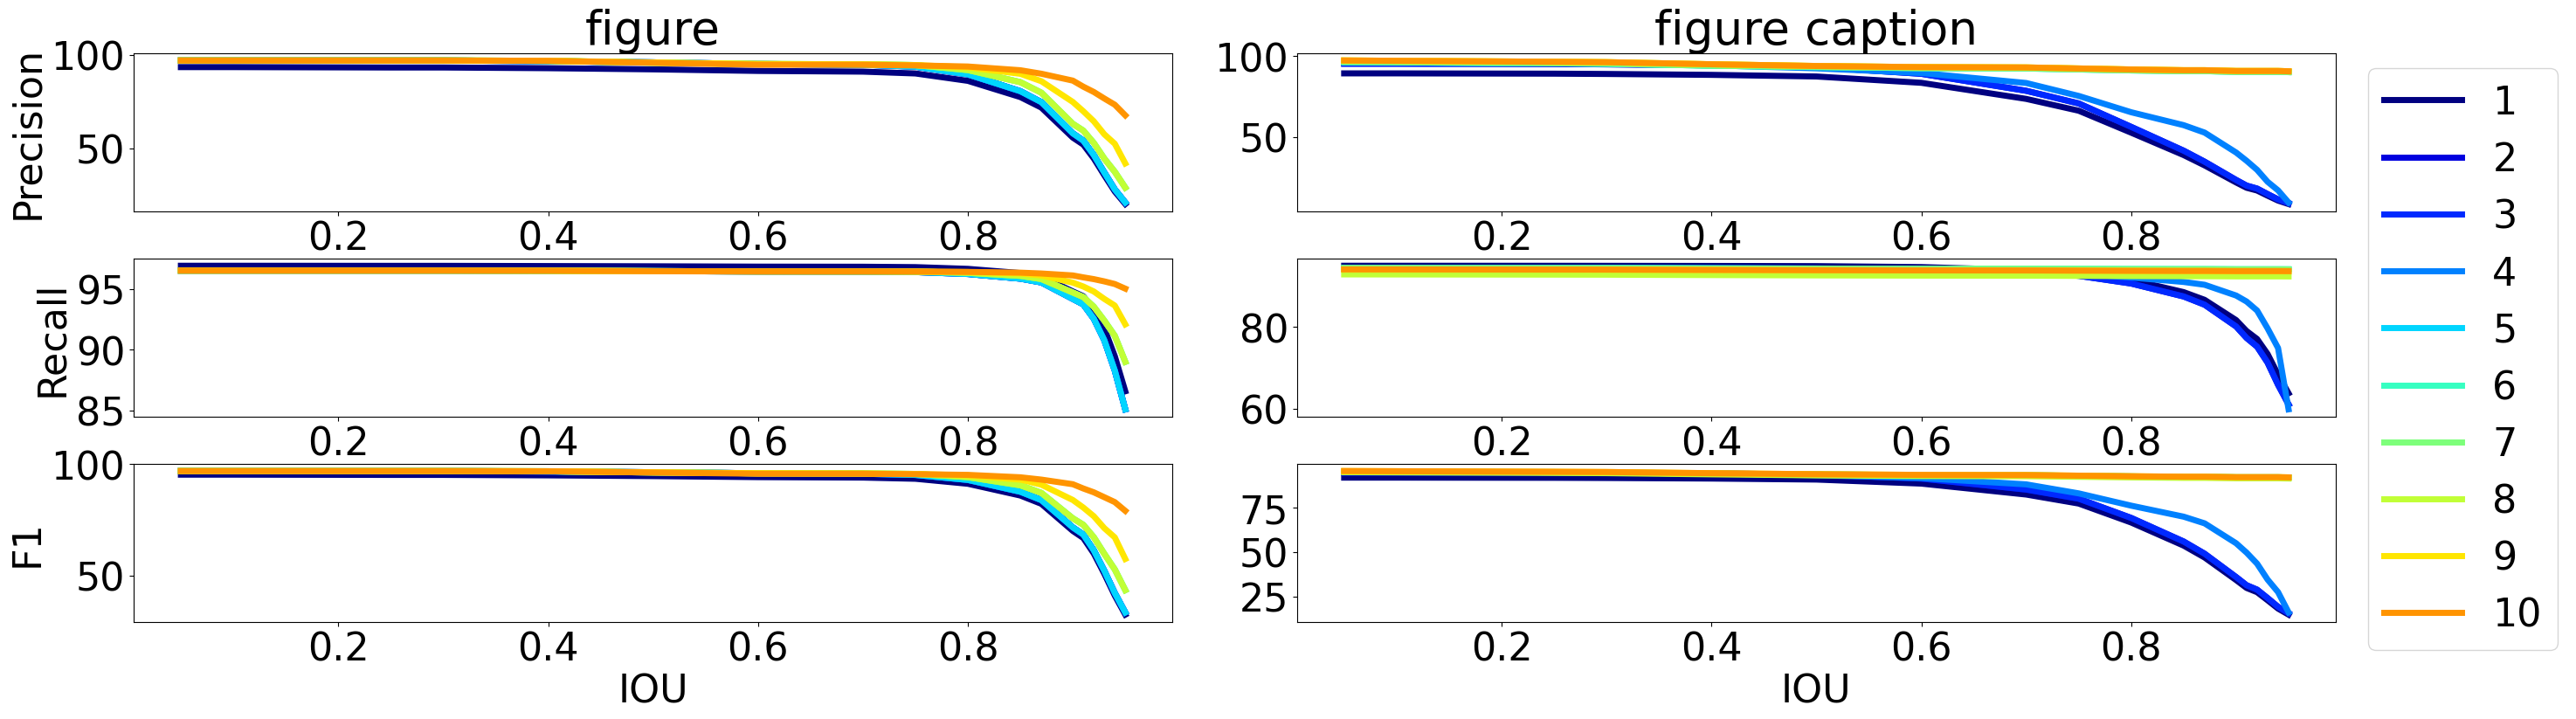

In [63]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 32})

if plot_post_proc:
    fig, ax = plt.subplots(3,len(LABELS[:2]),figsize=(30,9))
    for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
        lwh=lw
        #lwh=5
        #if ip==8: lwh=10
        #lwh = 8-ip
        for il in range(len(LABELS[:2])):
            if not divide_tt:
    #             ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
    #             ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
    #             ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
            else:
    #             ax[0][il].plot(iouvec2, tp[il]/tt[il]*100,color=colors[ip],lw=lwh)
    #             ax[1][il].plot(iouvec2, fp[il]/tt[il]*100,color=colors[ip],lw=lwh)
    #             ax[2][il].plot(iouvec2, fn[il]/tt[il]*100,color=colors[ip],lw=lwh)
                if il == 0:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
                else:
                    ax[0][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
                ax[1][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
                ax[2][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)

    for k in range(3): 
        ax[k][0].set_ylabel(ylabels[k+3])
        #for j in range(len(LABELS[:2])):
        #    ax[k][j].set_yscale('log')

    ax[0][0].set_title('figure')
    ax[0][1].set_title('figure caption')
    ax[2][0].set_xlabel('IOU')
    ax[2][1].set_xlabel('IOU')

    fig.legend(loc='center right')
    fig.tight_layout(rect=(0, 0, 0.92, 1))
    fig.subplots_adjust(hspace=0.3)
    fig.savefig(config.save_figures_dir + 'post_processing_tpdl.pdf')
    plt.show()

In [675]:
#fig.tight_layout?

## Save to .dat files if requestedsave_figures_dir

In [727]:
import os
# for final model test
#ioustar = [0.1, 0.6, 0.9]
#ioustar=[0.9]
#ioustar=[0.8]

In [728]:
n_cv_here = n_folds_cv
if not use_cv: n_cv_here = 1


if save_dats:
    # save too
    out_num_name = binary_dirs.split('/')[0]+adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2
    
    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')
        


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  truebox3,boxes_sq5,labels_sq5, 
                                                  scores_sq5,n_folds_cv=n_cv_here,seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # and mAP/AP
    for il,m in enumerate(aps[:lend]):
        with open(num_out_file + '_ap_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(round(m*100,1), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))                
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

                
print('all done! saved to:', num_out_file)

all done! saved to: /Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/tables/tolatex/binaries_model12_finaltest/binaries_model12_finaltest


In [678]:
binary_dirs

'binaries_model12_finaltest/'

In [729]:
#aps
import os

In [730]:
adder_dats2 = 'nopost'

if save_dats and save_no_post_proc:
    # save too
    out_num_name = adder_dats2
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')

    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  truebox1,boxes1,labels1, 
                                               scores1,n_folds_cv=n_cv_here,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')
    print('all done! saved to:', num_out_file)
print('all done!')

all done! saved to: /Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/tables/tolatex/nopost/nopost
all done!


In [681]:
# # quick thing to copy images to upload
# copyto = '/Users/jillnaiman/Downloads/tmp/test_touploaad/'
# copyfrom = config.images_jpeg_dir
# #print(imgs_name)
# import shutil
# for f in imgs_name:
#     fin = copyfrom+f.split('/')[-1].rstrip('.npz') + '.jpeg'
#     fout = copyto+f.split('/')[-1].rstrip('.npz') + '.jpeg'
#     #print(fout)
#     shutil.copyfile(fin,fout)